# Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings('ignore')

# Load data
file_path = '/content/Data_Master.csv'  # Path to the uploaded dataset
master_df = pd.read_csv(file_path)


In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Data Preprocessing for Modeling

In [ ]:
CALENDAR_CYCLES= {
    "weekday": 7,
    "week": 52,
    "month": 12,
}

In [ ]:
from typing import Union, List


def add_cyclical_calendar_features(df: pd.DataFrame, date_col: str, features: Union[str, List[str]]):
    """Cyclical encoding of calendar features based on a date column."""

    if isinstance(features, str):
        features = [features]

    # Ensure the date column is datetime
    df[date_col] = pd.to_datetime(df[date_col])

    for feat in features:
        assert (
            feat in CALENDAR_CYCLES.keys()
        ), f"Cyclical encoding is not available for {feat}"

        if feat == "week":
            # Use ISO calendar week
            values = df[date_col].dt.isocalendar().week
        else:
            # For other features (weekday, month), use .dt accessor
            values = getattr(df[date_col].dt, feat)

        # Apply cyclical encoding
        df[f"{feat}_sin"] = np.sin(2 * np.pi * values / CALENDAR_CYCLES[feat])
        df[f"{feat}_cos"] = np.cos(2 * np.pi * values / CALENDAR_CYCLES[feat])

    return df


In [ ]:
master_df_processed = add_cyclical_calendar_features(master_df, 'Date', features=["weekday", "week", 'month'])
master_df_processed
master_df['crude_lag_1year'] = master_df['crude'].shift(365)

# Preserve the original values for the first 365 rows
master_df.loc[:365, 'crude_lag_1year'] = master_df.loc[:365, 'crude']



In [ ]:
master_df_processed

,Date,s_p_500,interest_rate,vix,ovx,uso,dxy,crude,arabnews_m,cnbc_m,...,ft_b,mees_b,oilprice_b,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos,crude_lag_1year
0,2021-01-04,3700.65,0.09,26.97,42.12,32.38,89.87,47.47,0.4,0.0,...,-0.569241,0.000000,0.000000,0.000000,1.000000,0.120537,0.992709,0.500000,0.866025,47.47
1,2021-01-05,3726.86,0.09,25.34,40.39,33.94,89.44,49.78,0.4,0.4,...,-0.560321,0.000000,-0.526396,0.781831,0.623490,0.120537,0.992709,0.500000,0.866025,49.78
2,2021-01-06,3748.14,0.09,25.07,39.31,34.11,89.53,50.45,0.4,0.4,...,-0.654790,0.000000,-0.526396,0.974928,-0.222521,0.120537,0.992709,0.500000,0.866025,50.45
3,2021-01-07,3803.79,0.09,22.37,36.06,34.53,89.83,50.63,0.4,0.7,...,0.644426,0.000000,0.000000,0.433884,-0.900969,0.120537,0.992709,0.500000,0.866025,50.63
4,2021-01-08,3824.68,0.09,21.56,36.65,35.43,90.10,52.14,0.4,0.7,...,0.764327,-0.626426,0.711697,-0.433884,-0.900969,0.120537,0.992709,0.500000,0.866025,52.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,2024-10-06,5751.07,5.13,19.21,46.37,76.35,102.52,74.93,0.0,0.0,...,0.000000,0.000000,-0.788622,-0.781831,0.623490,-0.992709,0.120537,-0.866025,0.500000,82.83
1372,2024-10-07,5695.94,5.13,22.64,48.32,79.20,102.54,77.76,0.0,0.5,...,0.000000,0.000000,0.000000,0.000000,1.000000,-0.970942,0.239316,-0.866025,0.500000,82.83
1373,2024-10-08,5751.13,5.13,21.42,52.35,75.79,102.55,74.26,0.0,-0.3,...,-0.496074,0.000000,0.000000,0.781831,0.623490,-0.970942,0.239316,-0.866025,0.500000,82.83
1374,2024-10-09,5792.04,5.13,20.86,48.80,75.25,102.93,73.85,0.0,0.3,...,0.000000,0.000000,0.000000,0.974928,-0.222521,-0.970942,0.239316,-0.866025,0.500000,85.89


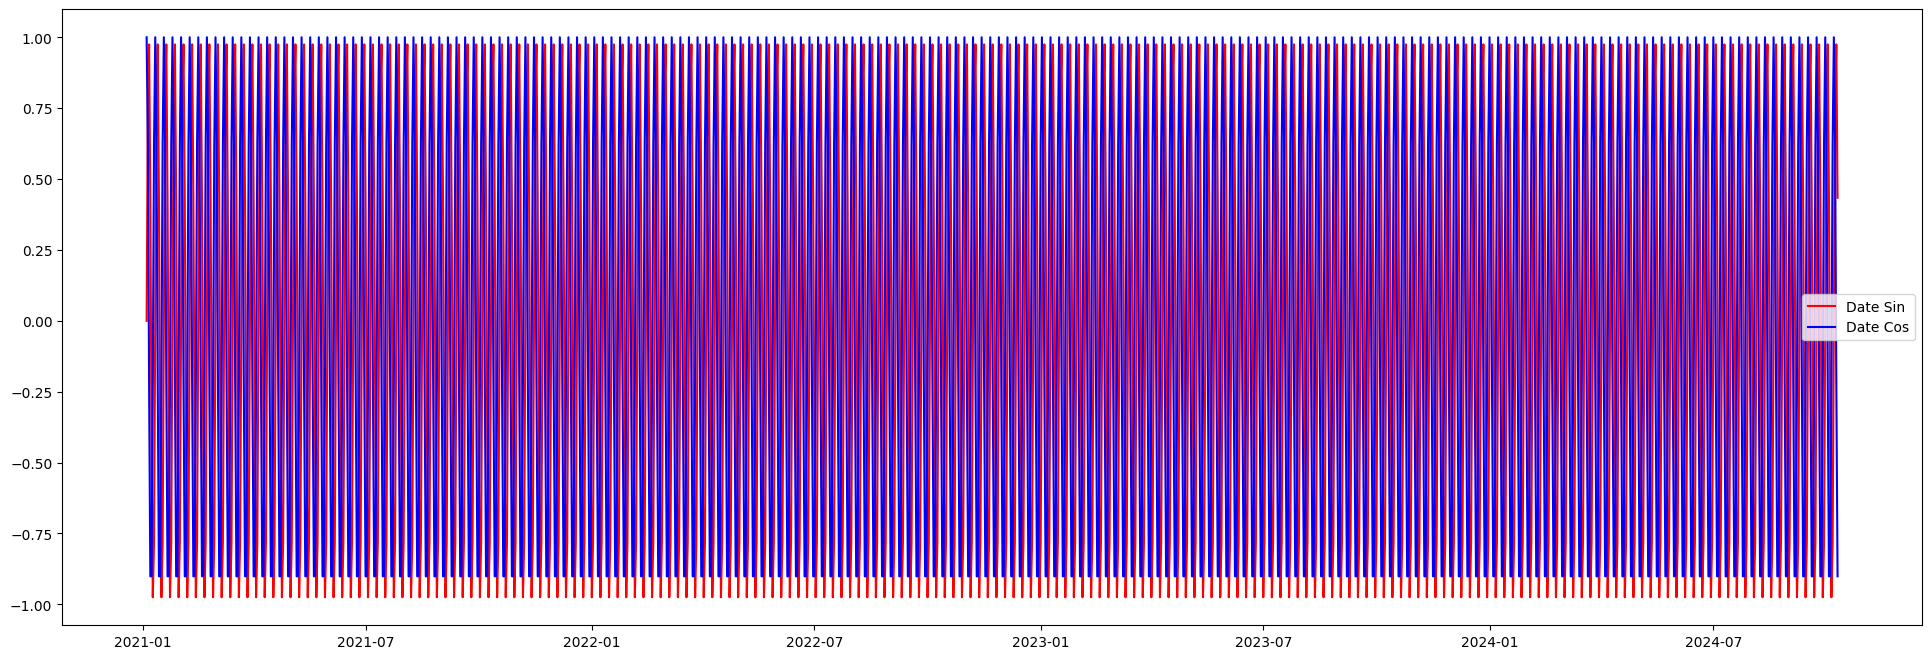

In [ ]:
plt.figure(figsize= (24,8))
plt.plot(master_df_processed['Date'], master_df_processed['weekday_sin'], c = 'r', label = 'Date Sin')
plt.plot(master_df_processed['Date'], master_df_processed['weekday_cos'], c = 'b', label = 'Date Cos')

plt.legend()

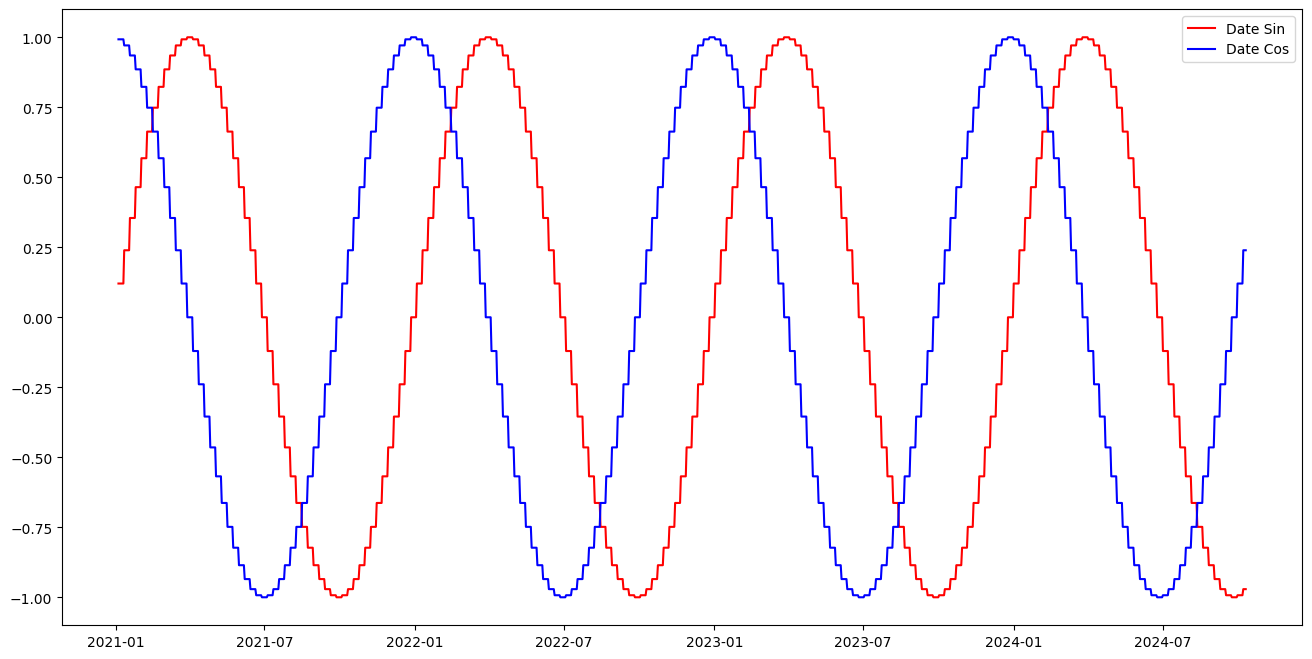

In [ ]:
plt.figure(figsize= (16,8))
plt.plot(master_df_processed['Date'], master_df_processed['week_sin'], c = 'r', label = 'Date Sin')
plt.plot(master_df_processed['Date'], master_df_processed['week_cos'], c = 'b', label = 'Date Cos')

plt.legend()

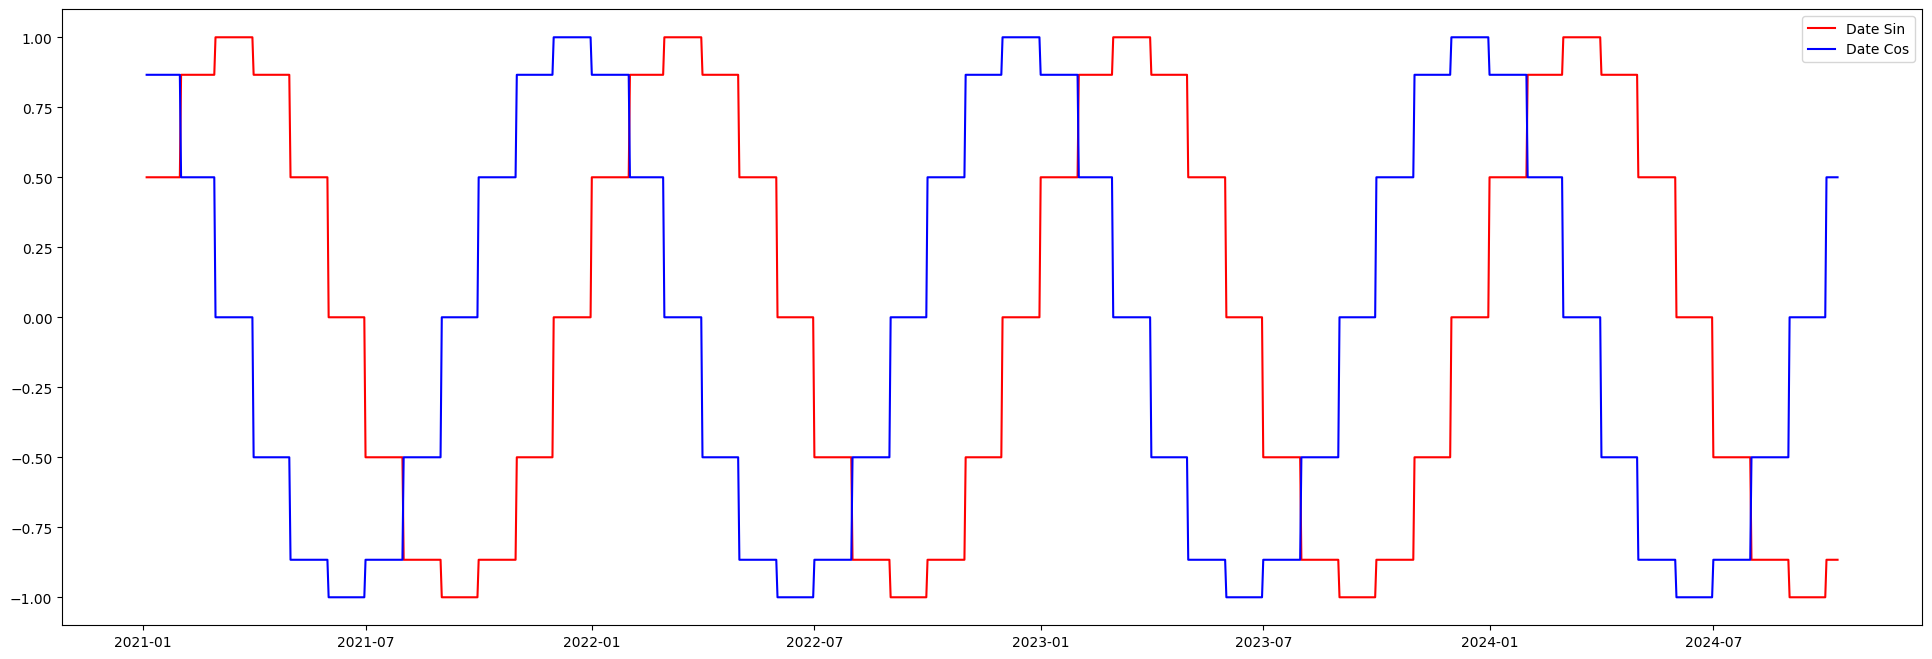

In [ ]:
plt.figure(figsize= (24,8))
plt.plot(master_df_processed['Date'], master_df_processed['month_sin'], c = 'r', label = 'Date Sin')
plt.plot(master_df_processed['Date'], master_df_processed['month_cos'], c = 'b', label = 'Date Cos')

plt.legend()

In [ ]:
plt.plot(master_df_processed[''])

In [ ]:
master_df[['crude_lag_1year']]

,crude_lag_1year
0,47.47
1,49.78
2,50.45
3,50.63
4,52.14
...,...
1371,82.83
1372,82.83
1373,82.83
1374,85.89


In [ ]:
# scaler = StandardScaler()
master_df_processed = master_df_processed[['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'dxy', 'crude', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
       'month_sin', 'month_cos', 'crude_lag_1year']]

exogenous_vars = [
 'weekday_sin',
 'weekday_cos',
 'week_sin',
 'week_cos',
 'month_sin',
 'month_cos',
 'crude_lag_1year'
 ]

In [ ]:

master_df_processed['Date'] = pd.to_datetime(master_df_processed['Date'], errors='coerce')
master_df_processed = master_df_processed[['Date', 'crude'] + exogenous_vars].rename(columns={'Date': 'ds', 'crude': 'y'})


split = round(len(master_df_processed)*0.8)
train = master_df_processed.iloc[: split]
test = master_df_processed.iloc[split:]

train = train.astype({col: 'float64' for col in train.select_dtypes(include='Float64').columns})
test = test.astype({col: 'float64' for col in test.select_dtypes(include='Float64').columns})


# Define endogenous variable and exogenous variables
y_train = train['y']
X_train = train[exogenous_vars]  # Exogenous variables for training
y_test = test['y']
X_test = test[exogenous_vars]  # Exogenous variables for testing



Forecasting for 16-day horizon...


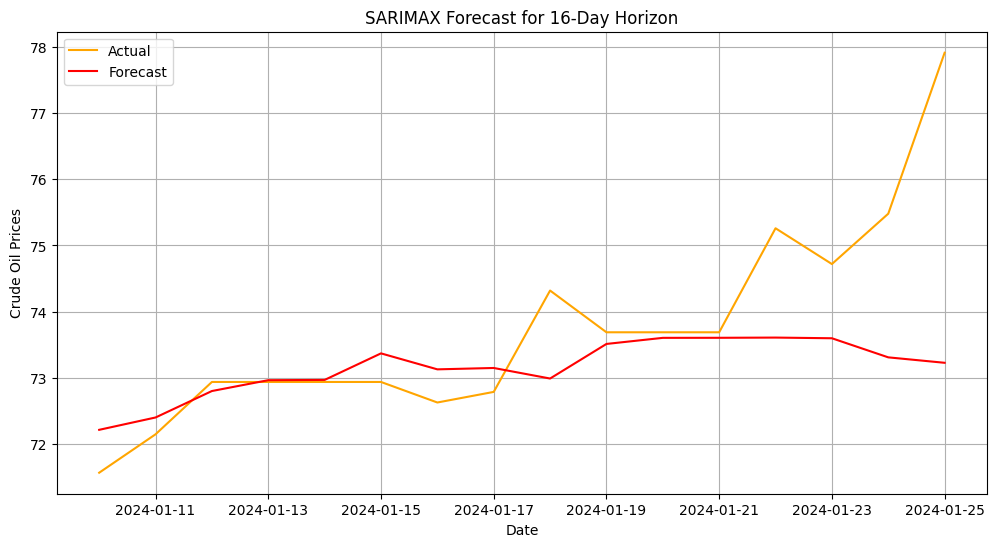

Forecasting for 48-day horizon...


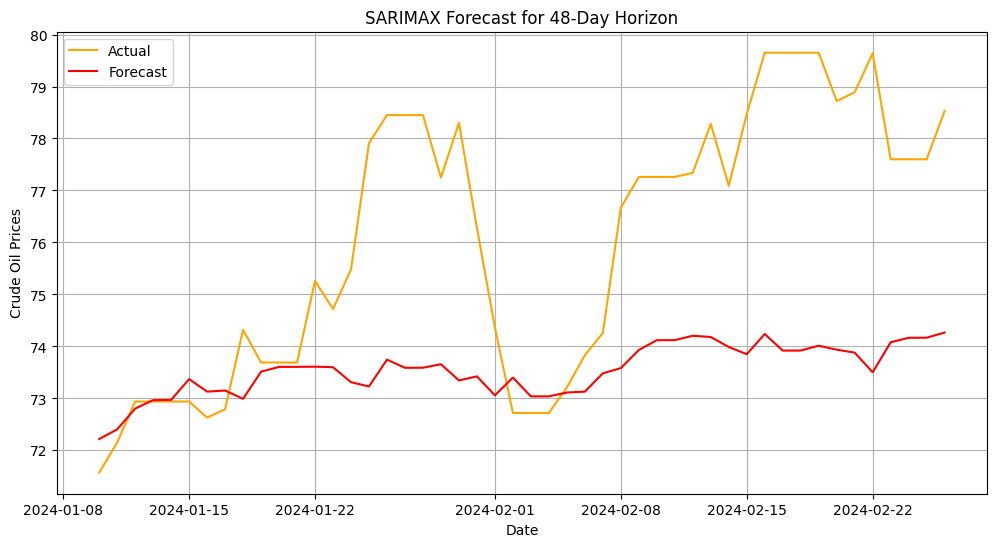

Forecasting for 96-day horizon...


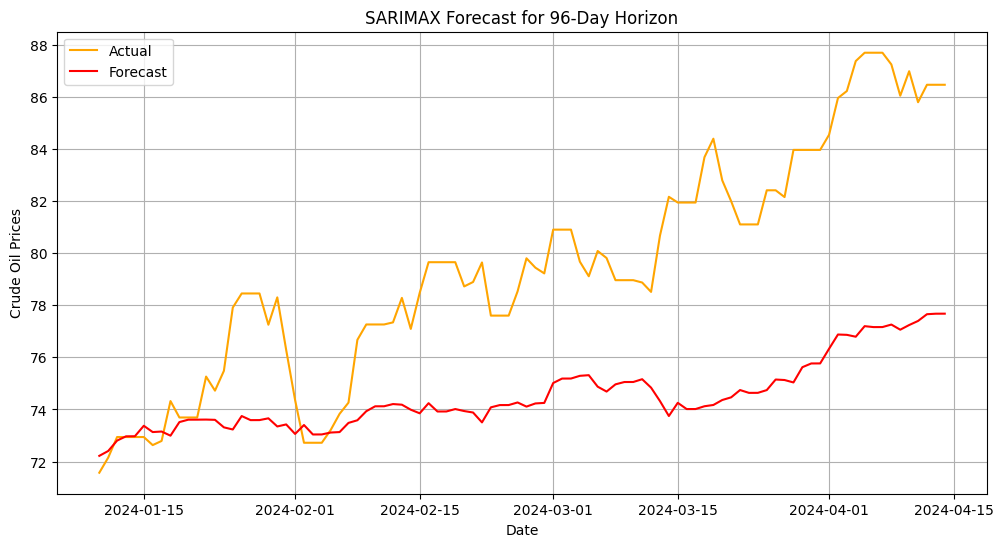

In [ ]:
horizons = [16,  48, 96]
results = {}



model = SARIMAX(
        endog=train['y'],
        exog=train[exogenous_vars],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7)
    )
sarimax_result = model.fit(disp=True)

for horizon in horizons:
    print(f"Forecasting for {horizon}-day horizon...")

    # Forecast
    forecast = sarimax_result.forecast(steps=horizon, exog=test[['weekday_sin',
 'weekday_cos',
 'week_sin',
 'week_cos',
 'month_sin',
 'month_cos',
'crude_lag_1year'
 ]].iloc[:horizon])

    # Evaluation
    actual = y_test[:horizon]
    mse = mean_squared_error(actual, forecast)
    rmse_value = np.sqrt(mse)
    mae_value = np.mean(np.abs(actual - forecast))
    mape_value = np.mean(np.abs((actual - forecast) / actual)) * 100
    smape_value = 100 * np.mean(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))

    # Store metrics
    results[horizon] = {

        'MAE': mae_value,

        'SMAPE': smape_value,
    }

    # Plot forecast results
    plt.figure(figsize=(12, 6))
    plt.plot(test['ds'].iloc[:horizon], actual, label='Actual', color='orange')
    plt.plot(test['ds'].iloc[:horizon], forecast, label='Forecast', color='red')
    plt.title(f'SARIMAX Forecast for {horizon}-Day Horizon')
    plt.xlabel('Date')
    plt.ylabel('Crude Oil Prices')
    plt.legend()
    plt.grid()
    plt.show()
    # Other metrics and plotting remain the same


In [ ]:

# Display evaluation metrics for all horizons
for horizon, metrics in results.items():
    print(f"\nResults for {horizon}-Day Horizon:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")



Results for 16-Day Horizon:
  MAE: 0.8550
  SMAPE: 1.1497

Results for 48-Day Horizon:
  MAE: 2.5925
  SMAPE: 3.4185

Results for 96-Day Horizon:
  MAE: 4.9639
  SMAPE: 6.3195


\[
\begin{array}{|c|c|c|c|}
\hline
\textbf{Model} & \textbf{Horizon} & \textbf{SMAPE} & \textbf{MAE} \\
\hline
\text{TFT} & \text{Small (16)} & 3.56 & 2.80 \\
\text{TFT} & \text{Medium (48)} & 7.36 & 6.96 \\
\text{TFT} & \text{Large (96)} & 10.37 & 8.55 \\
\hline
\text{PatchTST} & \text{Small (16)} & 3.15 & 2.47 \\
\text{PatchTST} & \text{Medium (48)} & 4.86 & 3.84 \\
\text{PatchTST} & \text{Large (96)} & 6.65 & 5.24 \\
\hline
\text{SARIMAX} & \text{16-Day Horizon} & 1.15 & 0.86 \\
\text{SARIMAX} & \text{48-Day Horizon} & 3.42 & 2.59 \\
\text{SARIMAX} & \text{96-Day Horizon} & 6.32 & 4.96 \\
\hline
\end{array}
\]


from IPython.display import display, Latex

display(Latex(r'''
\begin{array}{|c|c|c|c|}
\hline
\textbf{Horizon} & \textbf{Model} & \textbf{SMAPE} & \textbf{MAE} \\
\hline
\textbf{16 Steps} & \textbf{SARIMAX} & \textbf{1.1497} & \textbf{0.8550} \\
 & \text{PatchTST} & 3.15 & 2.47 \\
 & \textbf{TFT} & 3.56 & 2.80 \\
\hline
\textbf{48 Steps} & \textbf{SARIMAX} & 3.4185 & 2.5925 \\
 & \text{PatchTST} & 4.86 & 3.84 \\
 & \textbf{TFT} & \textbf{7.36} & 6.96 \\
\hline
\textbf{96 Steps} & \textbf{SARIMAX} & 6.3195 & 4.9639 \\
 & \text{PatchTST} & 6.65 & 5.24 \\
 & \textbf{TFT} & \textbf{10.37} & 8.55 \\
\hline
\end{array}
'''))


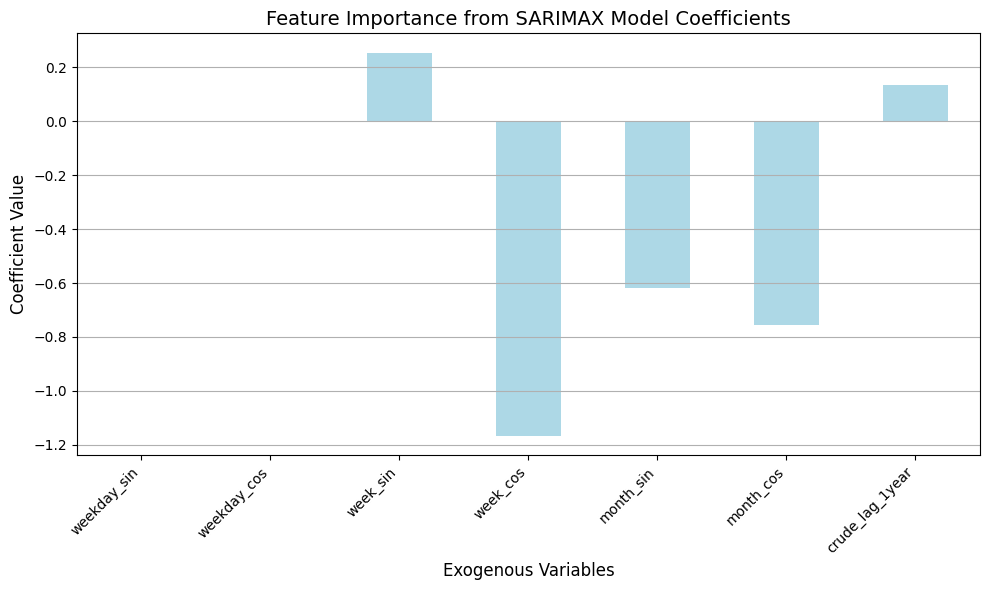

In [ ]:
import matplotlib.pyplot as plt

# Extract the coefficients
coefficients = sarimax_result.params

# Separate the exogenous variable coefficients (ignoring intercepts and AR terms)
exogenous_coeffs = coefficients[coefficients.index.isin(exogenous_vars)]

# Create the bar plot
plt.figure(figsize=(10, 6))
exogenous_coeffs.plot(kind='bar', color='lightblue')

# Add labels and title
plt.title('Feature Importance from SARIMAX Model Coefficients', fontsize=14)
plt.xlabel('Exogenous Variables', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define your test set and exogenous variables
test_data = test  # Assuming 'test' is your test dataset
exogenous_vars = [
    'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
    'month_sin', 'month_cos', 'crude_lag_1year'
]  # List of exogenous variables
y_test = test['y']  # Actual target values for the test set

# Model definition with training data
model = SARIMAX(
    endog=train['y'],  # Training data's target variable
    exog=train[exogenous_vars],  # Exogenous variables from training
    order=(1, 1, 1),  # SARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 7)  # Seasonal order (P, D, Q, S)
)
sarimax_result = model.fit(disp=True)

# Window size for rolling forecast
window_size = 16
predictions = []
windows = []
forecasts = []


# Sliding window: Predict on all windows of 16 data points
for start in range(len(test_data) - window_size + 1):
    end = start + window_size
    window = test_data.iloc[start:end]  # Slice the window from the test set
    windows.append(window)

    # Fit the SARIMAX model on the current window of dat

    # Forecast the next value (step 17) after the window

smapes = []
maes = []
e = 1e-8
for window in windows:
  forecast = sarimax_result.forecast(steps=16, exog=window[exogenous_vars])
  forecasts.append(forecast)
  forecast = forecast.values

  mae_value = mean_absolute_error(window['y'].values, forecast)  # Mean Absolute Error
  maes.append(mae_value)
  smape_value = smape(forecast, window['y'].values)
  #100 * np.mean(2 * np.abs(window['y'] - forecast) / (np.abs(window['y']) + np.abs(forecast)))  # SMAPE
  smapes.append(smape_value)

# Print evaluation metrics
print(f'MAE: {mae_value}')
print(f'SMAPE: {smape_value}')


MAE: 4.241878025157357
SMAPE: 5.787834887964117


In [ ]:
print(f'SMAPE {np.mean(smapes)}')
print(f'MAE {np.mean(maes)}')

SMAPE 6.826626207032399
MAE 5.30655773323598


In [ ]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define your test set and exogenous variables
test_data = test  # Assuming 'test' is your test dataset
exogenous_vars = [
    'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
    'month_sin', 'month_cos', 'crude_lag_1year'
]  # List of exogenous variables
y_test = test['y']  # Actual target values for the test set

# Model definition with training data
model = SARIMAX(
    endog=train['y'],  # Training data's target variable
    exog=train[exogenous_vars],  # Exogenous variables from training
    order=(1, 1, 1),  # SARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 7)  # Seasonal order (P, D, Q, S)
)
sarimax_result = model.fit(disp=True)

# Window size for rolling forecast
window_size = 48
predictions = []
windows = []
forecasts = []


# Sliding window: Predict on all windows of 16 data points
for start in range(len(test_data) - window_size + 1):
    end = start + window_size
    window = test_data.iloc[start:end]  # Slice the window from the test set
    windows.append(window)

    # Fit the SARIMAX model on the current window of dat

    # Forecast the next value (step 17) after the window

smapes = []
maes = []
e = 1e-8
for window in windows:
  forecast = sarimax_result.forecast(steps=48, exog=window[exogenous_vars])
  forecasts.append(forecast)
  forecast = forecast.values

  mae_value = mean_absolute_error(window['y'].values, forecast)  # Mean Absolute Error
  maes.append(mae_value)
  smape_value = smape(forecast, window['y'].values)
  #100 * np.mean(2 * np.abs(window['y'] - forecast) / (np.abs(window['y']) + np.abs(forecast)))  # SMAPE
  smapes.append(smape_value)

# Print evaluation metrics
print(f'MAE: {mae_value}')
print(f'SMAPE: {smape_value}')


MAE: 4.971167072639992
SMAPE: 6.738326400712251


In [ ]:
print(f'SMAPE {np.mean(smapes)}')
print(f'MAE {np.mean(maes)}')

SMAPE 6.722044121232557
MAE 5.2613167577377595


In [ ]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define your test set and exogenous variables
test_data = test  # Assuming 'test' is your test dataset
exogenous_vars = [
    'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
    'month_sin', 'month_cos', 'crude_lag_1year'
]  # List of exogenous variables
y_test = test['y']  # Actual target values for the test set

# Model definition with training data
model = SARIMAX(
    endog=train['y'],  # Training data's target variable
    exog=train[exogenous_vars],  # Exogenous variables from training
    order=(1, 1, 1),  # SARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 7)  # Seasonal order (P, D, Q, S)
)
sarimax_result = model.fit(disp=True)
can you use sl
# Window size for rolling forecast
window_size = 96
predictions = []
windows = []
forecasts = []


# Sliding window: Predict on all windows of 16 data points
for start in range(len(test_data) - window_size + 1):
    end = start + window_size
    window = test_data.iloc[start:end]  # Slice the window from the test set
    windows.append(window)

    # Fit the SARIMAX model on the current window of dat

    # Forecast the next value (step 17) after the window

smapes = []
maes = []
e = 1e-8
for window in windows:
  forecast = sarimax_result.forecast(steps=96, exog=window[exogenous_vars])
  forecasts.append(forecast)
  forecast = forecast.values

  mae_value = mean_absolute_error(window['y'].values, forecast)  # Mean Absolute Error
  maes.append(mae_value)
  smape_value = smape(forecast, window['y'].values)
  smapes.append(smape_value)

# Print evaluation metrics
print(f'MAE: {mae_value}')
print(f'SMAPE: {smape_value}')


MAE: 4.535440443036318
SMAPE: 5.976659537532475


In [ ]:
print(f'SMAPE {np.mean(smapes)}')
print(f'MAE {np.mean(maes)}')

SMAPE 6.641983308337991
MAE 5.236158464611808


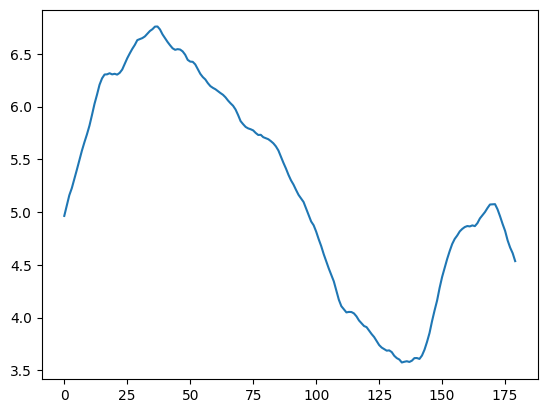

In [ ]:
plt.plot(maes)

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

from IPython.display import display, Latex

display(Latex(r'''
\begin{array}{|c|c|c|c|}
\hline
\textbf{Horizon} & \textbf{Model} & \textbf{SMAPE (%)} & \textbf{MAE (USD)} \\
\hline
\textbf{16 Steps} & \text{SARIMAX} & \text{6.82} & \text{5.30} \\
 & \textbf{PatchTST} & \textbf{3.15} & \textbf{2.47} \\
 & \text{TFT} & 3.56 & 2.80 \\
\hline
\textbf{48 Steps} & \text{SARIMAX} & 6.722 & 5.26 \\
 & \textbf{PatchTST} & \textbf{4.86} & \textbf{3.84} \\
 & \text{TFT} & \text{7.36} & 6.96 \\
\hline
\textbf{96 Steps} & \textbf{SARIMAX} & \textbf{6.4} & \textbf{5.23} \\
 & \text{PatchTST} & 6.65 & 5.24 \\
 & \text{TFT} & \text{10.37} & 8.55 \\
\hline
\end{array}
'''))


In [ ]:
MAPE 6.826626207032399
MAE 5.30655773323598

In [ ]:
SMAPE 6.722044121232557
MAE 5.2613167577377595

In [ ]:
SMAPE 6.641983308337991
MAE 5.236158464611808